# This is our workspace for data analysis!

In [1]:
# feel free to add more

import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Create connection to atlas
conn_atlas = sqlite3.connect('./atlas.db')
c_atlas = conn_atlas.cursor()

In [3]:
LIST_TABLES_CMD = "SELECT name FROM sqlite_master WHERE type='table';"
LIST_COLUMNS_CMD_ATLAS = "PRAGMA table_info('Atlas_of_Surveillance_20201007');"
c_atlas.execute(LIST_TABLES_CMD)
conn_atlas.commit()

for row in c_atlas:
  print(row)

c_atlas.execute(LIST_COLUMNS_CMD_ATLAS)
conn_atlas.commit()

for column in c_atlas:
    print(column)

('Atlas_of_Surveillance_20201007',)
('acs2015_county_data',)
('acs2017_county_data',)
(0, 'AOSNUMBER', 'TEXT', 0, None, 0)
(1, 'City', 'TEXT', 0, None, 0)
(2, 'County', 'TEXT', 0, None, 0)
(3, 'State', 'TEXT', 0, None, 0)
(4, 'Agency', 'TEXT', 0, None, 0)
(5, 'Type of LEA', 'TEXT', 0, None, 0)
(6, 'Summary', 'TEXT', 0, None, 0)
(7, 'Type of Juris', 'TEXT', 0, None, 0)
(8, 'Technology', 'TEXT', 0, None, 0)
(9, 'Vendor', 'TEXT', 0, None, 0)
(10, 'Link 1', 'TEXT', 0, None, 0)
(11, 'Link 1 Snapshot', 'TEXT', 0, None, 0)
(12, 'Link 1 Source', 'TEXT', 0, None, 0)
(13, 'Link 1 Type', 'TEXT', 0, None, 0)
(14, 'Link 1 Date', 'TEXT', 0, None, 0)
(15, 'Link 2', 'TEXT', 0, None, 0)
(16, 'Link 2 Snapshot', 'TEXT', 0, None, 0)
(17, 'Link 2 Source', 'TEXT', 0, None, 0)
(18, 'Link 2 Type', 'TEXT', 0, None, 0)
(19, 'Link 2 Date', 'TEXT', 0, None, 0)
(20, 'Link 3', 'TEXT', 0, None, 0)
(21, 'Link 3 Snapshot', 'TEXT', 0, None, 0)
(22, 'Link 3 Source', 'TEXT', 0, None, 0)
(23, 'Link 3 Type', 'TEXT', 0, Non

In [4]:
# Create connection to 2015
conn_2015 = sqlite3.connect('./us-census-data/2015.db')
c_2015 = conn_2015.cursor()

('acs2015_county_data',)
(0, 'CensusId', 'TEXT', 0, None, 0)
(1, 'State', 'TEXT', 0, None, 0)
(2, 'County', 'TEXT', 0, None, 0)
(3, 'TotalPop', 'TEXT', 0, None, 0)
(4, 'Men', 'TEXT', 0, None, 0)
(5, 'Women', 'TEXT', 0, None, 0)
(6, 'Hispanic', 'TEXT', 0, None, 0)
(7, 'White', 'TEXT', 0, None, 0)
(8, 'Black', 'TEXT', 0, None, 0)
(9, 'Native', 'TEXT', 0, None, 0)
(10, 'Asian', 'TEXT', 0, None, 0)
(11, 'Pacific', 'TEXT', 0, None, 0)
(12, 'Citizen', 'TEXT', 0, None, 0)
(13, 'Income', 'TEXT', 0, None, 0)
(14, 'IncomeErr', 'TEXT', 0, None, 0)
(15, 'IncomePerCap', 'TEXT', 0, None, 0)
(16, 'IncomePerCapErr', 'TEXT', 0, None, 0)
(17, 'Poverty', 'TEXT', 0, None, 0)
(18, 'ChildPoverty', 'TEXT', 0, None, 0)
(19, 'Professional', 'TEXT', 0, None, 0)
(20, 'Service', 'TEXT', 0, None, 0)
(21, 'Office', 'TEXT', 0, None, 0)
(22, 'Construction', 'TEXT', 0, None, 0)
(23, 'Production', 'TEXT', 0, None, 0)
(24, 'Drive', 'TEXT', 0, None, 0)
(25, 'Carpool', 'TEXT', 0, None, 0)
(26, 'Transit', 'TEXT', 0, None, 

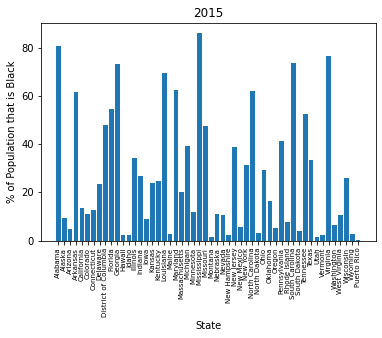

In [5]:
c_2015.execute(LIST_TABLES_CMD)
conn_2015.commit()

for row in c_2015:
  print(row)

LIST_COLUMNS_CMD_2015 = "PRAGMA table_info('acs2015_county_data');"

c_2015.execute(LIST_COLUMNS_CMD_2015)
conn_2015.commit()

for column in c_2015:
    print(column)

# Feel free to change to demographic groups
cursor_2015_black = conn_2015.cursor()
SELECT_BLACK_2015 = "SELECT Black from acs2015_county_data"
cursor_2015_black.execute(SELECT_BLACK_2015)

cursor_2015_state = conn_2015.cursor()
SELECT_STATE_2015 = "SELECT State from acs2015_county_data"
cursor_2015_state.execute(SELECT_STATE_2015)
black_2015 = [float(a[0]) for a in cursor_2015_black]
state_2015 = [a[0] for a in cursor_2015_state]

plot_state_race = plt.bar(state_2015, black_2015)
plt.title('2015')
plt.xlabel('State')
plt.ylabel('% of Population that is Black')
plt.xticks(fontsize=7, rotation=90)
plt.show()

In [6]:
# Create connection to 2017
conn_2017 = sqlite3.connect('./us-census-data/2017.db')
c_2017 = conn_2017.cursor()

In [7]:
c_2017.execute(LIST_TABLES_CMD)
conn_2017.commit()

LIST_COLUMNS_CMD_2017 = "PRAGMA table_info('acs2017_county_data');"

c_2017.execute(LIST_COLUMNS_CMD_2017)
conn_2017.commit()

for column in c_2017:
    print(column)
for row in c_2017:
  print(row)

(0, 'CountyId', 'TEXT', 0, None, 0)
(1, 'State', 'TEXT', 0, None, 0)
(2, 'County', 'TEXT', 0, None, 0)
(3, 'TotalPop', 'TEXT', 0, None, 0)
(4, 'Men', 'TEXT', 0, None, 0)
(5, 'Women', 'TEXT', 0, None, 0)
(6, 'Hispanic', 'TEXT', 0, None, 0)
(7, 'White', 'TEXT', 0, None, 0)
(8, 'Black', 'TEXT', 0, None, 0)
(9, 'Native', 'TEXT', 0, None, 0)
(10, 'Asian', 'TEXT', 0, None, 0)
(11, 'Pacific', 'TEXT', 0, None, 0)
(12, 'VotingAgeCitizen', 'TEXT', 0, None, 0)
(13, 'Income', 'TEXT', 0, None, 0)
(14, 'IncomeErr', 'TEXT', 0, None, 0)
(15, 'IncomePerCap', 'TEXT', 0, None, 0)
(16, 'IncomePerCapErr', 'TEXT', 0, None, 0)
(17, 'Poverty', 'TEXT', 0, None, 0)
(18, 'ChildPoverty', 'TEXT', 0, None, 0)
(19, 'Professional', 'TEXT', 0, None, 0)
(20, 'Service', 'TEXT', 0, None, 0)
(21, 'Office', 'TEXT', 0, None, 0)
(22, 'Construction', 'TEXT', 0, None, 0)
(23, 'Production', 'TEXT', 0, None, 0)
(24, 'Drive', 'TEXT', 0, None, 0)
(25, 'Carpool', 'TEXT', 0, None, 0)
(26, 'Transit', 'TEXT', 0, None, 0)
(27, 'Walk', 

# OLS workspace
- array with number of each race in a county (multiply percentage by total pop)
- array with total number of surveillance devices in a county (need SQL query for this)
    - SQL query to join 

In [8]:
# Number of black people in each county
# black_2015

# Feel free to change to demographic groups
cursor_2015_total_pop = conn_2015.cursor()
SELECT_TOTAL_POP_2015 = "SELECT TotalPop from acs2015_county_data"
cursor_2015_total_pop.execute(SELECT_TOTAL_POP_2015)
total_pop_2015 = [float(a[0]) for a in cursor_2015_total_pop]
total_pop_black_2015 = []
for i in range(len(total_pop_2015)) :
    total_pop_black_2015.append(total_pop_2015[i] * black_2015[i])

In [13]:
# select *
# from Db1.dbo.Clients c
# join Db2.dbo.Messages m on c.ClientId = m.ClientId


JOIN_QUERY = ' SELECT * FROM Atlas_of_Surveillance_20201007 INNER JOIN acs2015_county_data ON acs2015_county_data.County = Atlas_of_Surveillance_20201007.County;'
c_atlas = conn_atlas.cursor()
c_atlas.execute(JOIN_QUERY)
conn_atlas.commit()
i = 0
for row in c_atlas:
  print(row, "\n")
  print("I:", i)
  i += 1

('AOS1573', 'Fairbanks', 'Fairbanks North Star Borough', 'AK', 'Fairbanks Police Department', 'Police', 'The Fairbanks Police Department operates one DJI Inspire drone as of 2017, according to data compiled by the Center for the Study of the Drone at Bard College.', 'Municipal', 'Drones', 'DJI', 'https://dronecenter.bard.edu/projects/public-safety-drones-project/public-safety-drones-3rd-edition/', '', 'Center for the Study of the Drone at Bard College', '', '2020', '', '', '', '', '', '', '', '', '', '', '2090', 'Alaska', 'Fairbanks North Star Borough', '99705', '53477', '46228', '7.4', '71.9', '4.1', '5.7', '2.6', '0.6', '72964', '71068.0', '1964.0', '33244', '1103', '8.1', '9.9', '36.6', '17.0', '23.4', '12.9', '10.1', '74.0', '14.3', '1.5', '3.6', '3.3', '3.4', '19.2', '46661', '65.8', '29.9', '4.1', '0.2', '7.9') 

I: 0
('AOS2770', 'Salinas', 'Monterey', 'CA', 'Salinas Police Department', 'Police', 'The Salinas Police Department started using ShotSpotter gunshot detection technolog